In [0]:
# STEP 0 — Start Spark session (run once)
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TravelTourism").getOrCreate()


In [0]:

import random
from datetime import datetime, timedelta
import pandas as pd

random.seed(42)

customers = [
    ("C001", "Rahul Verma", "Hyderabad"),
    ("C002", "Sneha Reddy", "Bangalore"),
    ("C003", "Amit Singh", "Delhi"),
    ("C004", "Priya Sharma", "Mumbai"),
    ("C005", "Arjun Nair", "Chennai"),
    ("C006", "Kavya Iyer", "Pune"),
    ("C007", "Rohit Das", "Kolkata"),
    ("C008", "Meera Menon", "Hyderabad"),
    ("C009", "Vikram Rao", "Bangalore"),
    ("C010", "Ananya Gupta", "Delhi")
]

hotels = [
    ("H101", "Taj Deccan", "Hyderabad"),
    ("H102", "ITC Kakatiya", "Hyderabad"),
    ("H103", "The Oberoi", "Delhi"),
    ("H104", "Leela Palace", "Bangalore"),
    ("H105", "Taj Lands End", "Mumbai"),
    ("H106", "Park Hyatt", "Chennai"),
    ("H107", "JW Marriott", "Pune"),
    ("H108", "The Lalit", "Kolkata")
]

statuses = ["booked", "cancelled"]
ratings = [3.0, 3.5, 4.0, 4.2, 4.5, 4.8, 5.0]

rows = []
for i in range(1, 81):
    cust = random.choice(customers)
    hotel = random.choice(hotels)
    booking_id = f"B{i:03d}"
    booking_date = datetime(2025, 1, 1) + timedelta(days=random.randint(0, 240))
    stay_duration = random.randint(1, 7)
    amount_spent = stay_duration * random.randint(2000, 7000)
    status = random.choices(statuses, weights=[0.85, 0.15])[0]  # more bookings than cancels
    rating = random.choice(ratings) if status == "booked" else None

    rows.append({
        "customer_id": cust[0],
        "customer_name": cust[1],
        "city": cust[2],
        "hotel_id": hotel[0],
        "hotel_name": hotel[1],
        "hotel_city": hotel[2],
        "booking_id": booking_id,
        "booking_date": booking_date.strftime("%Y-%m-%d"),
        "stay_duration": stay_duration,
        "amount_spent": amount_spent,
        "status": status,
        "rating": rating
    })

pdf = pd.DataFrame(rows)
# Create Spark DataFrame from Pandas
df = spark.createDataFrame(pdf)
# Convert booking_date to DateType
from pyspark.sql.functions import to_date, col
df = df.withColumn("booking_date", to_date(col("booking_date"), "yyyy-MM-dd"))

# Quick preview
print("Rows:", df.count())
df.show(5, truncate=False)


Rows: 80
+-----------+-------------+---------+--------+-------------+----------+----------+------------+-------------+------------+---------+------+
|customer_id|customer_name|city     |hotel_id|hotel_name   |hotel_city|booking_id|booking_date|stay_duration|amount_spent|status   |rating|
+-----------+-------------+---------+--------+-------------+----------+----------+------------+-------------+------------+---------+------+
|C002       |Sneha Reddy  |Bangalore|H101    |Taj Deccan   |Hyderabad |B001      |2025-07-09  |3            |12018       |booked   |4.8   |
|C002       |Sneha Reddy  |Bangalore|H102    |ITC Kakatiya |Hyderabad |B002      |2025-06-01  |4            |9040        |booked   |3.5   |
|C004       |Priya Sharma |Mumbai   |H101    |Taj Deccan   |Hyderabad |B003      |2025-05-24  |2            |12928       |booked   |4.2   |
|C010       |Ananya Gupta |Delhi    |H105    |Taj Lands End|Mumbai    |B004      |2025-07-27  |7            |14371       |booked   |3.5   |
|C007      

In [0]:
# STEP 2 — Core analysis (same as earlier)
from pyspark.sql.functions import sum, avg, month, date_format, round

# Total revenue per hotel (booked only)
revenue_per_hotel = (
    df.filter(col("status") == "booked")
      .groupBy("hotel_id", "hotel_name")
      .agg(sum("amount_spent").alias("total_revenue"))
      .orderBy(col("total_revenue").desc())
)
revenue_per_hotel.show(truncate=False)

# Avg stay duration by city (booked only)
avg_stay_by_city = (
    df.filter(col("status") == "booked")
      .groupBy("city")
      .agg(round(avg("stay_duration"), 2).alias("avg_stay_duration"))
      .orderBy(col("avg_stay_duration").desc())
)
avg_stay_by_city.show(truncate=False)


+--------+-------------+-------------+
|hotel_id|hotel_name   |total_revenue|
+--------+-------------+-------------+
|H105    |Taj Lands End|238548       |
|H103    |The Oberoi   |222376       |
|H106    |Park Hyatt   |194234       |
|H102    |ITC Kakatiya |147779       |
|H101    |Taj Deccan   |132074       |
|H104    |Leela Palace |122434       |
|H108    |The Lalit    |103102       |
|H107    |JW Marriott  |46250        |
+--------+-------------+-------------+

+---------+-----------------+
|city     |avg_stay_duration|
+---------+-----------------+
|Kolkata  |5.5              |
|Pune     |4.6              |
|Delhi    |4.22             |
|Chennai  |4.22             |
|Mumbai   |4.0              |
|Bangalore|4.0              |
|Hyderabad|3.67             |
+---------+-----------------+



In [0]:
# STEP 3 — SQL analysis (cancellation rates, seasonal trends)
df.createOrReplaceTempView("bookings")
# add month columns
df_with_month = df.withColumn("month_num", month("booking_date")) \
                  .withColumn("month_name", date_format(col("booking_date"), "MMM"))
df_with_month.createOrReplaceTempView("bookings_m")

cancellation_rates = spark.sql("""
SELECT hotel_id, hotel_name,
       100.0 * SUM(CASE WHEN status='cancelled' THEN 1 ELSE 0 END) / COUNT(*) AS cancellation_rate
FROM bookings
GROUP BY hotel_id, hotel_name
ORDER BY cancellation_rate DESC
""")
cancellation_rates.show(truncate=False)

seasonal_trends = spark.sql("""
SELECT month_num AS month, month_name, city,
       SUM(amount_spent) AS total_revenue, COUNT(*) AS total_bookings
FROM bookings_m
WHERE status='booked'
GROUP BY month_num, month_name, city
ORDER BY month, city
""")
seasonal_trends.show(truncate=False)


+--------+-------------+-----------------+
|hotel_id|hotel_name   |cancellation_rate|
+--------+-------------+-----------------+
|H107    |JW Marriott  |40.00000000000000|
|H104    |Leela Palace |36.36363636363636|
|H108    |The Lalit    |28.57142857142857|
|H101    |Taj Deccan   |22.22222222222222|
|H106    |Park Hyatt   |18.18181818181818|
|H103    |The Oberoi   |17.64705882352941|
|H102    |ITC Kakatiya |0.00000000000000 |
|H105    |Taj Lands End|0.00000000000000 |
+--------+-------------+-----------------+

+-----+----------+---------+-------------+--------------+
|month|month_name|city     |total_revenue|total_bookings|
+-----+----------+---------+-------------+--------------+
|1    |Jan       |Bangalore|71253        |2             |
|1    |Jan       |Chennai  |9213         |1             |
|1    |Jan       |Hyderabad|6785         |1             |
|1    |Jan       |Mumbai   |54924        |2             |
|1    |Jan       |Pune     |11168        |1             |
|2    |Feb       |B

In [0]:
# STEP 4 — Visualize (Databricks display() or matplotlib)
# Use display() to make it easy to download results from Databricks UI
display(revenue_per_hotel)
display(avg_stay_by_city)
display(cancellation_rates)
display(seasonal_trends)


hotel_id,hotel_name,total_revenue
H105,Taj Lands End,238548
H103,The Oberoi,222376
H106,Park Hyatt,194234
H102,ITC Kakatiya,147779
H101,Taj Deccan,132074
H104,Leela Palace,122434
H108,The Lalit,103102
H107,JW Marriott,46250


city,avg_stay_duration
Kolkata,5.5
Pune,4.6
Delhi,4.22
Chennai,4.22
Bangalore,4.0
Mumbai,4.0
Hyderabad,3.67


hotel_id,hotel_name,cancellation_rate
H107,JW Marriott,40.00000000000000
H104,Leela Palace,36.36363636363636
H108,The Lalit,28.57142857142857
H101,Taj Deccan,22.22222222222222
H106,Park Hyatt,18.18181818181818
H103,The Oberoi,17.64705882352941
H102,ITC Kakatiya,0E-14
H105,Taj Lands End,0E-14


month,month_name,city,total_revenue,total_bookings
1,Jan,Bangalore,71253,2
1,Jan,Chennai,9213,1
1,Jan,Hyderabad,6785,1
1,Jan,Mumbai,54924,2
1,Jan,Pune,11168,1
2,Feb,Bangalore,20420,1
2,Feb,Delhi,46503,2
2,Feb,Hyderabad,67448,3
2,Feb,Mumbai,48570,2
3,Mar,Bangalore,39914,2


In [0]:
# STEP 4 — Visualize (Databricks display() or matplotlib)
# Use display() to make it easy to download results from Databricks UI
display(revenue_per_hotel)
display(avg_stay_by_city)
display(cancellation_rates)
display(seasonal_trends)


hotel_id,hotel_name,total_revenue
H105,Taj Lands End,238548
H103,The Oberoi,222376
H106,Park Hyatt,194234
H102,ITC Kakatiya,147779
H101,Taj Deccan,132074
H104,Leela Palace,122434
H108,The Lalit,103102
H107,JW Marriott,46250


city,avg_stay_duration
Kolkata,5.5
Pune,4.6
Delhi,4.22
Chennai,4.22
Bangalore,4.0
Mumbai,4.0
Hyderabad,3.67


hotel_id,hotel_name,cancellation_rate
H107,JW Marriott,40.00000000000000
H104,Leela Palace,36.36363636363636
H108,The Lalit,28.57142857142857
H101,Taj Deccan,22.22222222222222
H106,Park Hyatt,18.18181818181818
H103,The Oberoi,17.64705882352941
H102,ITC Kakatiya,0E-14
H105,Taj Lands End,0E-14


month,month_name,city,total_revenue,total_bookings
1,Jan,Bangalore,71253,2
1,Jan,Chennai,9213,1
1,Jan,Hyderabad,6785,1
1,Jan,Mumbai,54924,2
1,Jan,Pune,11168,1
2,Feb,Bangalore,20420,1
2,Feb,Delhi,46503,2
2,Feb,Hyderabad,67448,3
2,Feb,Mumbai,48570,2
3,Mar,Bangalore,39914,2


Hotels with Highest Cancellation Rates:
+--------+-------------+-----------------+
|hotel_id|   hotel_name|cancellation_rate|
+--------+-------------+-----------------+
|    H107|  JW Marriott|40.00000000000000|
|    H104| Leela Palace|36.36363636363636|
|    H108|    The Lalit|28.57142857142857|
|    H101|   Taj Deccan|22.22222222222222|
|    H106|   Park Hyatt|18.18181818181818|
|    H103|   The Oberoi|17.64705882352941|
|    H102| ITC Kakatiya| 0.00000000000000|
|    H105|Taj Lands End| 0.00000000000000|
+--------+-------------+-----------------+



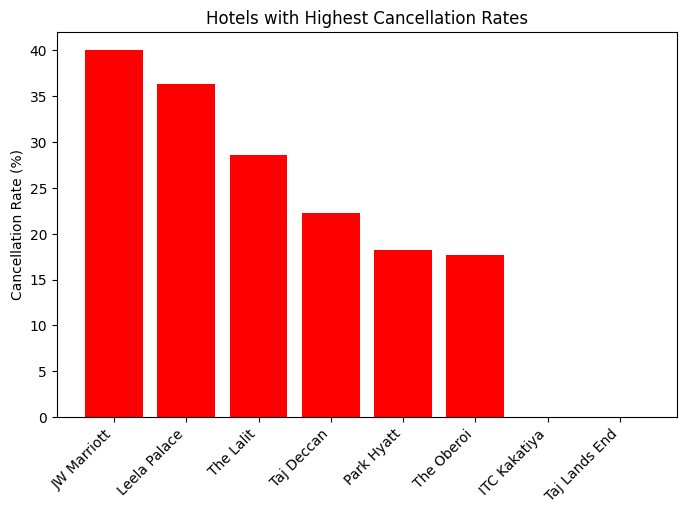

In [0]:

df.createOrReplaceTempView("bookings")

# SQL to calculate cancellation rate per hotel
cancellation_rates = spark.sql("""
SELECT hotel_id, hotel_name,
       COUNT(CASE WHEN status='cancelled' THEN 1 END) * 100.0 / COUNT(*) AS cancellation_rate
FROM bookings
GROUP BY hotel_id, hotel_name
ORDER BY cancellation_rate DESC
""")

print("Hotels with Highest Cancellation Rates:")
cancellation_rates.show()

# Convert to Pandas for plotting
pdf_cancel = cancellation_rates.toPandas()

# Plot bar chart
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(pdf_cancel['hotel_name'], pdf_cancel['cancellation_rate'], color='red')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cancellation Rate (%)")
plt.title("Hotels with Highest Cancellation Rates")
plt.show()


Seasonal Trends (Revenue by Month & City):
+-----+---------+-------------+
|month|     city|total_revenue|
+-----+---------+-------------+
|    1|Bangalore|        71253|
|    1|  Chennai|         9213|
|    1|Hyderabad|         6785|
|    1|   Mumbai|        54924|
|    1|     Pune|        11168|
|    2|Bangalore|        20420|
|    2|    Delhi|        46503|
|    2|Hyderabad|        67448|
|    2|   Mumbai|        48570|
|    3|Bangalore|        39914|
|    3|  Chennai|        35231|
|    3|    Delhi|         4958|
|    3|Hyderabad|        42885|
|    4|Bangalore|        49982|
|    4|    Delhi|        18389|
|    4|Hyderabad|        44510|
|    4|  Kolkata|        39589|
|    4|   Mumbai|        49828|
|    4|     Pune|        30945|
|    5|Bangalore|        29054|
+-----+---------+-------------+
only showing top 20 rows


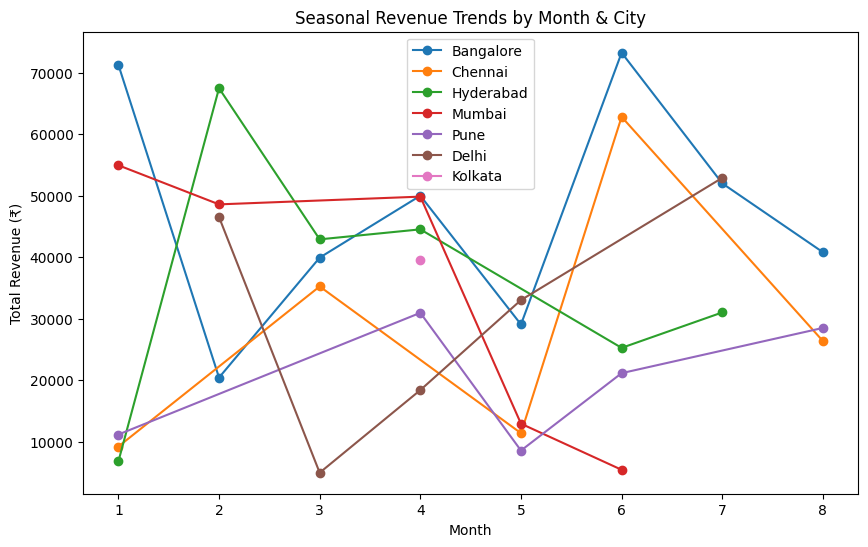

In [0]:
from pyspark.sql.functions import month
import matplotlib.pyplot as plt

# Add month column from booking_date
df_with_month = df.withColumn("month", month("booking_date"))

# Register as SQL view
df_with_month.createOrReplaceTempView("bookings_with_month")

# SQL: total revenue grouped by month & city
seasonal_trends = spark.sql("""
SELECT month, city,
       SUM(amount_spent) AS total_revenue
FROM bookings_with_month
WHERE status='booked'
GROUP BY month, city
ORDER BY month, city
""")

print("Seasonal Trends (Revenue by Month & City):")
seasonal_trends.show()

# Convert to Pandas for chart
pdf_trends = seasonal_trends.toPandas()

# Plot revenue trends
plt.figure(figsize=(10,6))
for city in pdf_trends['city'].unique():
    subset = pdf_trends[pdf_trends['city'] == city]
    plt.plot(subset['month'], subset['total_revenue'], marker='o', label=city)

plt.xlabel("Month")
plt.ylabel("Total Revenue (₹)")
plt.title("Seasonal Revenue Trends by Month & City")
plt.legend()
plt.show()


Total Revenue per Hotel:
+-------------+-------------+
|   hotel_name|total_revenue|
+-------------+-------------+
|Taj Lands End|       238548|
|   The Oberoi|       222376|
|   Park Hyatt|       194234|
| ITC Kakatiya|       147779|
|   Taj Deccan|       132074|
| Leela Palace|       122434|
|    The Lalit|       103102|
|  JW Marriott|        46250|
+-------------+-------------+



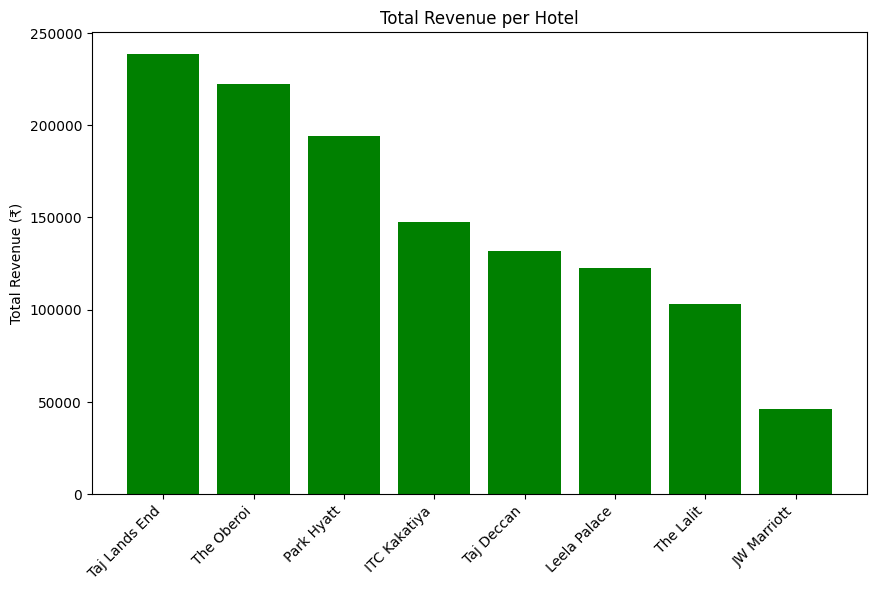

In [0]:
import matplotlib.pyplot as plt

# SQL to calculate total revenue per hotel
revenue_per_hotel = spark.sql("""
SELECT hotel_name,
       SUM(amount_spent) AS total_revenue
FROM bookings
WHERE status='booked'
GROUP BY hotel_name
ORDER BY total_revenue DESC
""")

print("Total Revenue per Hotel:")
revenue_per_hotel.show()

# Convert to Pandas for plotting
pdf_revenue = revenue_per_hotel.toPandas()

# Plot bar chart
plt.figure(figsize=(10,6))
plt.bar(pdf_revenue['hotel_name'], pdf_revenue['total_revenue'], color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Revenue (₹)")
plt.title("Total Revenue per Hotel")
plt.show()


Average Stay Duration by City:
+---------+------------------+
|     city| avg_stay_duration|
+---------+------------------+
|  Kolkata|               5.5|
|     Pune|               4.6|
|    Delhi| 4.222222222222222|
|  Chennai| 4.222222222222222|
|   Mumbai|               4.0|
|Bangalore|               4.0|
|Hyderabad|3.6666666666666665|
+---------+------------------+



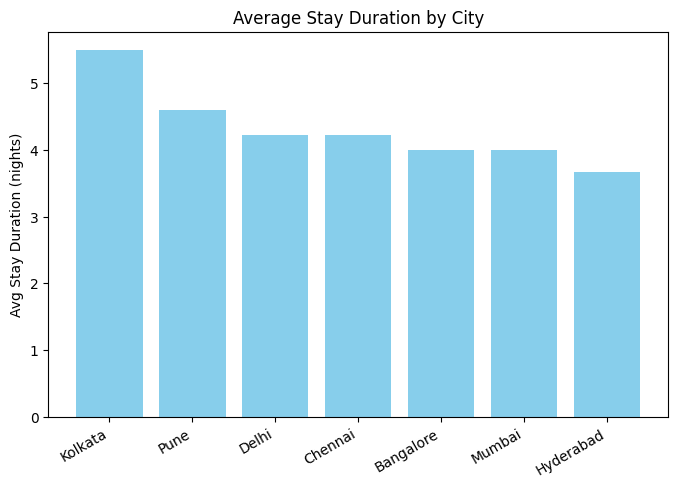

In [0]:
import matplotlib.pyplot as plt

# SQL to calculate avg stay duration per city
avg_stay = spark.sql("""
SELECT city,
       AVG(stay_duration) AS avg_stay_duration
FROM bookings
WHERE status='booked'
GROUP BY city
ORDER BY avg_stay_duration DESC
""")

print("Average Stay Duration by City:")
avg_stay.show()

# Convert to Pandas for chart
pdf_stay = avg_stay.toPandas()

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(pdf_stay['city'], pdf_stay['avg_stay_duration'], color='skyblue')
plt.xticks(rotation=30, ha='right')
plt.ylabel("Avg Stay Duration (nights)")
plt.title("Average Stay Duration by City")
plt.show()


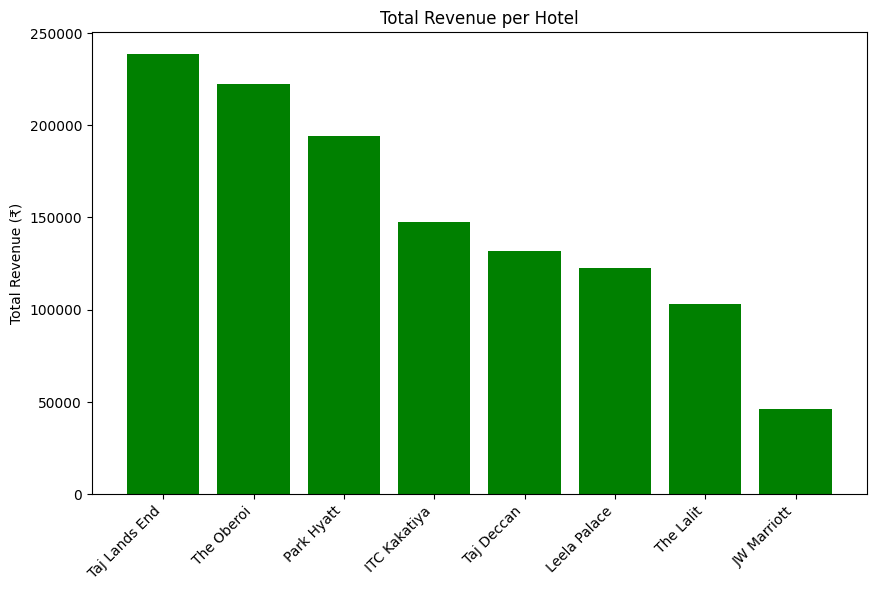

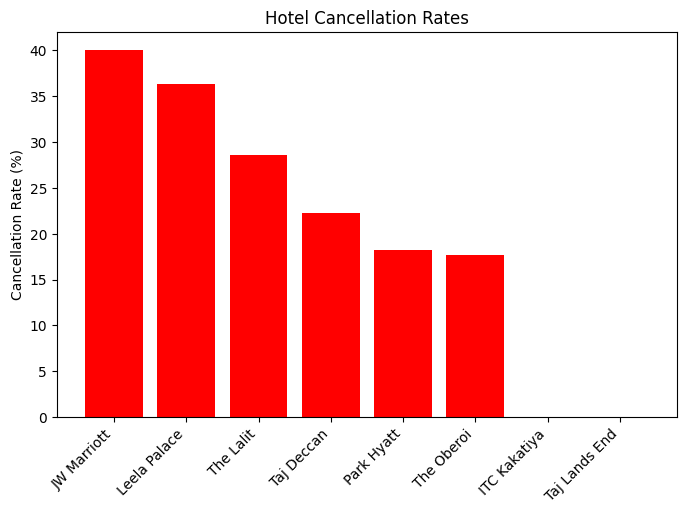

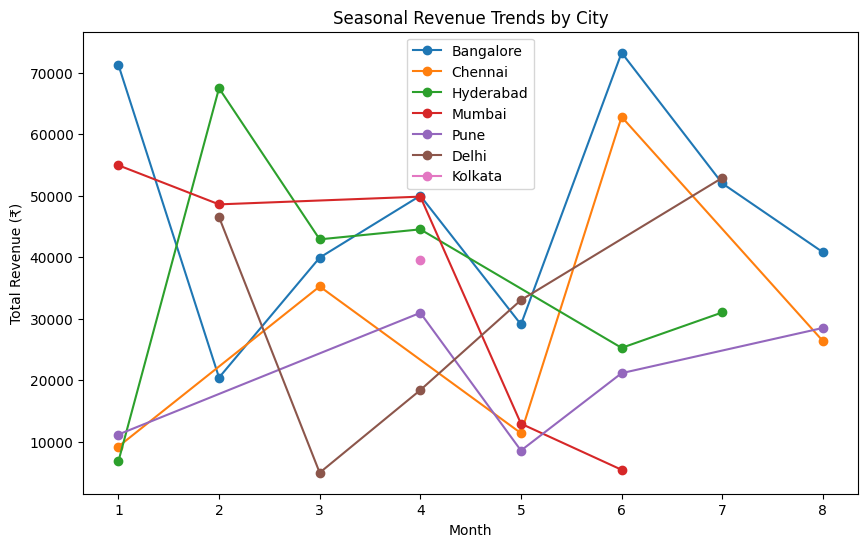

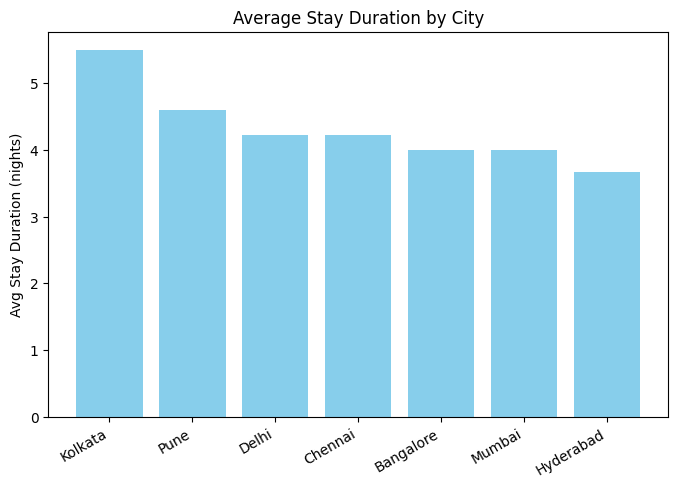

In [0]:
from pyspark.sql.functions import month
import matplotlib.pyplot as plt

# ------------------------------------------
# 1. Total Revenue per Hotel
# ------------------------------------------
revenue_per_hotel = spark.sql("""
SELECT hotel_name,
       SUM(amount_spent) AS total_revenue
FROM bookings
WHERE status='booked'
GROUP BY hotel_name
ORDER BY total_revenue DESC
""")

pdf_revenue = revenue_per_hotel.toPandas()
plt.figure(figsize=(10,6))
plt.bar(pdf_revenue['hotel_name'], pdf_revenue['total_revenue'], color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total Revenue (₹)")
plt.title("Total Revenue per Hotel")
plt.show()


# ------------------------------------------
# 2. Cancellation Rates by Hotel
# ------------------------------------------
cancellation_rates = spark.sql("""
SELECT hotel_name,
       COUNT(CASE WHEN status='cancelled' THEN 1 END) * 100.0 / COUNT(*) AS cancellation_rate
FROM bookings
GROUP BY hotel_name
ORDER BY cancellation_rate DESC
""")

pdf_cancel = cancellation_rates.toPandas()
plt.figure(figsize=(8,5))
plt.bar(pdf_cancel['hotel_name'], pdf_cancel['cancellation_rate'], color='red')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Cancellation Rate (%)")
plt.title("Hotel Cancellation Rates")
plt.show()


# ------------------------------------------
# 3. Seasonal Trends (Revenue by Month & City)
# ------------------------------------------
df_with_month = df.withColumn("month", month("booking_date"))
df_with_month.createOrReplaceTempView("bookings_with_month")

seasonal_trends = spark.sql("""
SELECT month, city, SUM(amount_spent) AS total_revenue
FROM bookings_with_month
WHERE status='booked'
GROUP BY month, city
ORDER BY month, city
""")

pdf_trends = seasonal_trends.toPandas()
plt.figure(figsize=(10,6))
for city in pdf_trends['city'].unique():
    subset = pdf_trends[pdf_trends['city'] == city]
    plt.plot(subset['month'], subset['total_revenue'], marker='o', label=city)
plt.xlabel("Month")
plt.ylabel("Total Revenue (₹)")
plt.title("Seasonal Revenue Trends by City")
plt.legend()
plt.show()


# ------------------------------------------
# 4. Average Stay Duration by City
# ------------------------------------------
avg_stay = spark.sql("""
SELECT city,
       AVG(stay_duration) AS avg_stay_duration
FROM bookings
WHERE status='booked'
GROUP BY city
ORDER BY avg_stay_duration DESC
""")

pdf_stay = avg_stay.toPandas()
plt.figure(figsize=(8,5))
plt.bar(pdf_stay['city'], pdf_stay['avg_stay_duration'], color='skyblue')
plt.xticks(rotation=30, ha='right')
plt.ylabel("Avg Stay Duration (nights)")
plt.title("Average Stay Duration by City")
plt.show()
